---
<center><img src="images/RWTH.jpg" width=600></center>

<h1 align="center"> Machine learning approaches for the prediction of oxygen evolution catalysts. </h1> 
<h1 align="center"> Dr. Stefan Palkovits </h1>
<h1 align="center"> <a href="stefan.palkovits@itmc.rwth-aachen.de">stefan.palkovits@itmc.rwth-aachen.de </a> </h1>
<h1 align="center"> <a href="https://twitter.com/palkovitslab?lang=de">@PalkovitsLab</a> </h1>

---

In [1]:
from IPython.display import IFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import altair as alt

%matplotlib inline

In this work we will use several Machine Learning algorithms to predict the overpotential of water oxidation catalysts. The models will be evaluated against each other.

Two datasets will be used:

* J. A. Haber, Y. Cai, S. Jung, C. Xiang, S. Mitrovic, J. Jin, A. T. Bell, J. M. Gregoire, Energy Environ. Sci., 2014, 7, 682–688, DOI: 10.1039/c3ee43683g

* J. A. Haber, C. Xiang, D. Guevarra, S. Jung, J. Jin, J. M. Gregoire, ChemElectroChem 2014, 1, 524 – 528, DOI: 10.1002/celc.201300229

The data from the supplementory information is already compiled for your convenience in a single csv file. 

# Data visualization and preprocessing

First we have to load the data with the help of pandas.

In [2]:
NiFeCoCe_full = pd.read_csv('./data/full_dataset.csv')
NiFeCoCe_own = pd.read_csv('./data/own_dataset.csv')

And we take a look at it with the *head* function.

In [3]:
NiFeCoCe_full.head()

,Ni,Fe,Co,Ce,Overpotential
0,1.000,0.000,0.000,0.0,441.0
1,0.969,0.031,0.000,0.0,426.0
2,0.969,0.000,0.031,0.0,423.0
3,0.929,0.071,0.000,0.0,420.0
4,0.929,0.031,0.031,0.0,422.0


So in the data is just the elemental composition and the measured respective overpotential.

---
## Visualization of the raw data

We will mix in some more sophistic visualization tools. Apart from the 'standard' Matplotlib we will use Seaborn for more modern graphics and moreover we will use Altair to have some additional features. Altair differs from Matplotlib and Seaborn as it wants you to specify the graphs in a declarative way to lead the focus on the actual visualization and not on the code for it.

First it is often useful remove the limit in the entries that Altair can deal with. Maybe this is not necessary in later versions.

In [4]:
IFrame(src='https://altair-viz.github.io/', width=900, height=450)

In [5]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

As you see in the next cell Altair works pretty different. We tell Altair

* that we want a chart made from which dataframe,
* how the markers should look like
* and what encodings to use for X and Y.

What we get is a decent looking graph which we can directly save if we want to.

In [6]:
alt.Chart(NiFeCoCe_full).mark_circle().encode(
    alt.X('Ni', type='quantitative'),
    alt.Y('Overpotential', type='quantitative'),
)

alt.Chart(...)

If we want some kind of pairplot we have to extend this syntax. We add the rows and columns which we want to repeat and the size of the overall graph. And one power of Altair is the possible interactivity of the graphs which we also add.

In [7]:
alt.Chart(NiFeCoCe_full).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=200,
    height=200
).repeat(
    row=['Overpotential'],
    column=['Ni', 'Fe', 'Co', 'Ce']
).interactive()

alt.RepeatChart(...)

---

## Clustering with k-means algorithm and further visualization with the t-distributed Stochastic Neighbor Embedding (t-SNE) algorithm

To look for structures in the data we will go ahead now with some Unsupervised Learning. Although Principal Component Analysis is often very useful this time it would fail (Try it!). So we will use a combination of

* k-Means Clustering and
* t-distributed stochastic neighbor embedding (t-SNE)

for Unsupervised Learning and visualization.

In [8]:
IFrame(src='https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding', width=900, height=450)

So lets first import the k-MEans algorithm.

In [9]:
from sklearn.cluster import KMeans

And now we do an exploratory elbow curve by initiating a set of k-Means instances in a for loop and fitting it to the dataset. Then we calculated the score to evaluate the performance of each clustering with respect to its size. The resulting plot can be found a little further down together with the results from t-SNE.

In [10]:
k_ellbow = []

for E in range(20):
    E = E+1
    kmeans = KMeans(n_clusters=E)
    kmeans.fit(NiFeCoCe_full.loc[:,'Ni':'Ce'])
    score = kmeans.score(NiFeCoCe_full.loc[:,'Ni':'Ce'])
    k_ellbow.append(score)

And of course we do a final clustering and predict with entry in the dataset belongs to which cluster.

In [11]:
k_cluster = KMeans(n_clusters=10)
k_cluster.fit(NiFeCoCe_full.loc[:,'Ni':'Ce'])
y_k_cluster = k_cluster.predict(NiFeCoCe_full.loc[:,'Ni':'Ce'])

And now we import the t-SNE algorithm.

In [12]:
from sklearn.manifold import TSNE

Again we initiate one instance of the algorithm with the respective hyperparameters. The *n_components* is easy to guess as we want a projection in a xy-plane but especially the perplexity is sometimes hard to figure out in this case 30 works decent.

In [13]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, init='pca')
tsne_result = tsne.fit_transform(NiFeCoCe_full.loc[:,'Ni':'Ce'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6074 samples in 0.004s...
[t-SNE] Computed neighbors for 6074 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6074
[t-SNE] Computed conditional probabilities for sample 2000 / 6074
[t-SNE] Computed conditional probabilities for sample 3000 / 6074
[t-SNE] Computed conditional probabilities for sample 4000 / 6074
[t-SNE] Computed conditional probabilities for sample 5000 / 6074
[t-SNE] Computed conditional probabilities for sample 6000 / 6074
[t-SNE] Computed conditional probabilities for sample 6074 / 6074
[t-SNE] Mean sigma: 0.044124
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.439438
[t-SNE] KL divergence after 1000 iterations: 1.349010


And now we plot everything together. From the elbow plot on the left one sees that 10 seems to be a decent cluster amount. On the right hand side it seems that t-SNE was able to spread the data nice into the plane and using the cluster number for the coloring shows that the 10 cluster do not mix much. Apart from Seaborn here a *GridSpec* from Matplotlib is used to get a nice looking distribution of the plots.

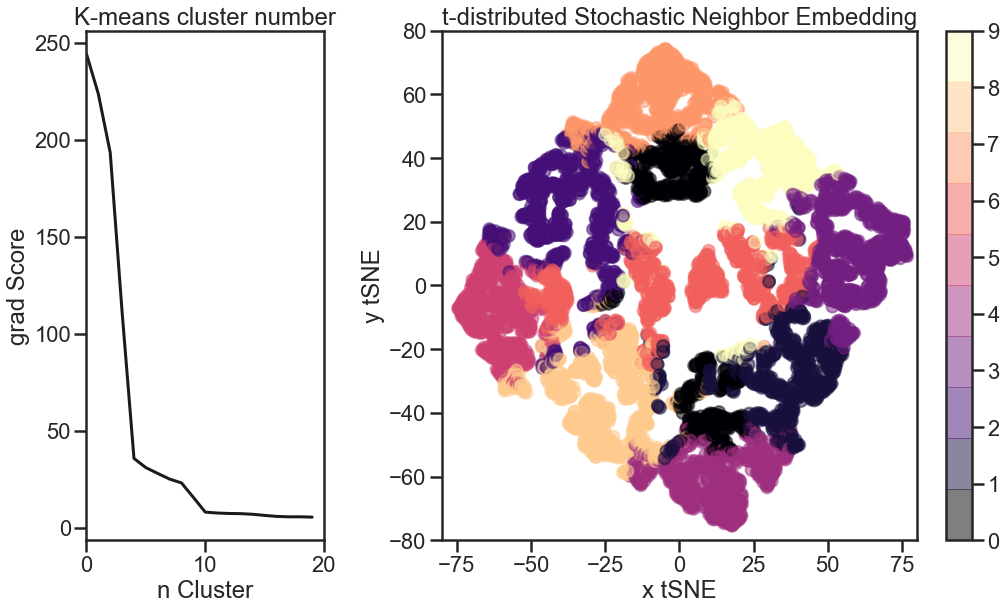

In [14]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(15,9))
grid = plt.GridSpec(1,3)

plt.subplot(grid[0,0])
plt.xlim(0, 20)
plt.title('K-means cluster number')
plt.xlabel('n Cluster')
plt.ylabel('grad Score')
plt.plot(np.gradient(k_ellbow), 'k')

plt.subplot(grid[0,1:])
plt.xlim((-80,80))
plt.ylim((-80,80))
plt.title('t-distributed Stochastic Neighbor Embedding')
plt.xlabel('x tSNE')
plt.ylabel('y tSNE')
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=y_k_cluster, marker='o',alpha=0.5, cmap=plt.cm.get_cmap('magma', 10))
plt.colorbar(ticks=np.arange(0,12))

plt.tight_layout();

In order to not mess up the dataset during the next visualization we now make a copy of the dataset and add the cluster numbers to the dataframe.

In [15]:
Cluster_Visualization = NiFeCoCe_full.copy()
Cluster_Visualization['Cluster'] = pd.Series(y_k_cluster, dtype=str)

As we are in a browser with Jupyter we can to pretty nice visualizations with Altair. The next one is a variation of the pairplot from above. We added not only the clustering information on top of the pairplot as color but we are able to chose the cluster from a drop-down field and while hovering over a datapoint we can see the actual composition as tooltip. This helps us to get the information from the Unsupervised LEarning back to a format that is easier to interpret.

In [16]:
input_dropdown = alt.binding_select(options=['0','1','2', '3', '4', '5', '6', '7', '8'])
selection = alt.selection_single(fields=['Cluster'], bind=input_dropdown, name='Number ')
color = alt.condition(selection,
                    alt.Color('Cluster:N'),
                    alt.value('lightgray'))

chart = alt.Chart(Cluster_Visualization).mark_circle().encode(
    x='Ni',
    y='Overpotential',
    color=color,
    tooltip=['Ni', 'Fe', 'Co', 'Ce']
).properties(
    width=200,
    height=200
).add_selection(
    selection
)

chart | chart.encode(x='Co') | chart.encode(x='Fe') | chart.encode(x='Ce')

alt.HConcatChart(...)

---

## Sorting, splitting by overpotential and preprocessing for the Machine Learning algorithms

Before we can go on with Supervised Learning we have to take some care about the splitting of the dataset. When we want to predict the overpotential then it is useful to know that it is desirable for a catalyst to produce an overpotential that is as low as possible. But there are only very few samples with a low overpotential in the dataset. To ensure that the samples with a low overpotential are available in both, the training and the test dataset, we first have to split the dataset and cut the low overpotentials in a separate set. Now it is sure that we have less than 150 samples with a low overpotential.

In [17]:
NiFeCoCe_new = NiFeCoCe_full.sort_values(by=['Overpotential'])

NiFeCoCe_small_OP = NiFeCoCe_new[NiFeCoCe_new['Overpotential']<380]
NiFeCoCe_large_OP = NiFeCoCe_new[NiFeCoCe_new['Overpotential']>=380]

print('Samples with a low overpotential: ', NiFeCoCe_small_OP.shape)
print('Samples with a high overpotential', NiFeCoCe_large_OP.shape)

Samples with a low overpotential:  (146, 5)
Samples with a high overpotential (5928, 5)


Now we do a *train_test_split* of both datasets and add the training and test portions together again. Now we can be sure that the training and test set have the same fraction of low overpotential samples.

In [18]:
from sklearn.model_selection import train_test_split

X1_train, y1_test = train_test_split(NiFeCoCe_large_OP, test_size=0.3, random_state=42)
X2_train, y2_test = train_test_split(NiFeCoCe_small_OP, test_size=0.3, random_state=42)

NiFeCoCe_train = np.vstack((X1_train, X2_train))
NiFeCoCe_test = np.vstack((y1_test, y2_test))

print('Training samples: ', NiFeCoCe_train.shape)
print('Test samples: ', NiFeCoCe_test.shape)

Training samples:  (4251, 5)
Test samples:  (1823, 5)


Now we to a final shuffling of the data.

In [19]:
np.random.seed(42)

order1 = np.argsort(np.random.random(NiFeCoCe_train[:,-1].shape))
order2 = np.argsort(np.random.random(NiFeCoCe_test[:,-1].shape))

NiFeCoCe_train = NiFeCoCe_train[order1]
NiFeCoCe_test = NiFeCoCe_test[order2]

And here we cut the features from the targets and divide the targets by 1000.

In [20]:
train_data = NiFeCoCe_train[:,0:4]
train_label = NiFeCoCe_train[:,-1]/1000

test_data = NiFeCoCe_test[:,0:4]
test_label = NiFeCoCe_test[:,-1]/1000

---

# Artificial Neural Network Approach

So let us try a Neural Network (NN) first. There are some basic things about NNs you should know:

* Neural Networks are state-of-the-art Machine Learning algorithms
* Features mark the inputs
* Targets are the outputs
* The neurons are connected by weights
* Each neuron has an additional activation function
    
<center><img src="images/network2.png" width=400></center>

The library to create the NN will be Tensorflow by Google. If you have not worked with NNs this is a decent choice as the synthax is quite simple. But there are other possibilities out there. The most prominent one is for example PyTorch. What both libraries have in common is that they use the Keras API to define the network structure. On top of it then sits Tensorflow or PyTorch to do the calculations.

So lets first import everything needed from Tensorflow and let us also add the import of a mean squared error (mse).

In [21]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_squared_error

print('Tensorflow version: ' + tf.__version__)

Tensorflow version: 2.4.1


Tensorflow has internal callbacks. Here we define an early stopping callback that monitors of the validation loss is not changing for a certain time.

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

Let us figure out which network structure works good. We therefore postulate a network, an optimizer, compile everything and fit the model. But we put everything in a loop and very in the layers the amount of neurons and see what works best. We therefore also make a prediction and write the resultimg error into a list. Then we get a plot of the resulting error versus the node number. This procedure takes a little time and in order to decide if a new optimization is needed everything is put into a conditional.

In [23]:
optimize = 'n'

if optimize == 'y':

    neuron_list = np.arange(2, 32, 2)
    neuron_error = []

    for neuron in neuron_list:

        model_opt = keras.Sequential([
            layers.Dense(neuron, activation='relu', input_shape=(train_data.shape[1],)),
            layers.Dense(neuron, activation='relu'),
            layers.Dense(1)
            ])

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

        model_opt.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

        model_opt.fit(train_data, train_label, epochs=500, validation_split=0.2, verbose=0, callbacks=[early_stop])

        epochs = model_opt.history.epoch[-1]

        predictions_ann = model_opt.predict(test_data).flatten()

        error_ann = np.sqrt(mean_squared_error(test_label,predictions_ann))

        neuron_error.append(error_ann)

        print('\r', 'Neurons used =', neuron, 'Error =', error_ann, 'Epochs =', epochs, end='')

    print(' Done!')

    sns.set()
    sns.set(style='ticks', context='poster')
    plt.figure(figsize=(12,9))

    plt.xlabel('Neurons used')
    plt.ylabel('Mean squared error')
    plt.plot(neuron_list, neuron_error);

Now we have a decent idea what model would work. We design a final one with 6 neurons inj each layer, choose and optimizer, compile and fit the network.

In [45]:
model = tf.keras.models.Sequential([
    layers.Dense(6, activation='relu', input_shape=(train_data.shape[1],)),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
])
    
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
model.fit(train_data, train_label, epochs=500, validation_split=0.2, verbose=0, callbacks=[early_stop]);

With Tensorflow we can now get a summary of the network we designed. You can see that even this simple model has 79 adjustable weights.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


## Metrics of the Artificial Neural Network

Tensorflow calculates some metrics in a default history callback. We can create some plots out of it the loss tells us that we do not seem to overfit. Moreover, the mean absolute error is quite low, so we can continue with this model.

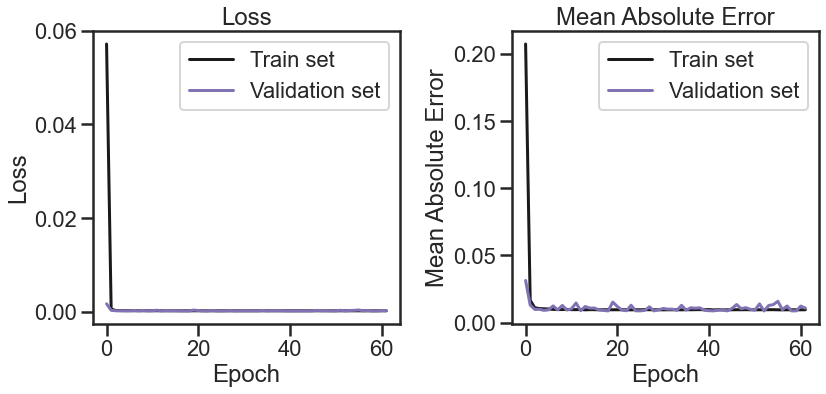

In [26]:
sns.set()
sns.set(style='ticks', context='poster', palette='magma')
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(model.history.epoch, np.array(model.history.history['loss']), 'k',label='Train set')
plt.plot(model.history.epoch, np.array(model.history.history['val_loss']), 'm', label='Validation set')
plt.legend()

plt.subplot(122)
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.plot(model.history.epoch, np.array(model.history.history['mae']), 'k', label='Train set')
plt.plot(model.history.epoch, np.array(model.history.history['val_mae']), 'm', label='Validation set')
plt.legend()
         
plt.tight_layout()

Next we make some predictions with the trained model on the training and test set which we will use mostly a little later. And me make also some predictions on some real wet chemistry OER catalysts prepared and measured in AK Palkovits.

In [27]:
train_predictions = model.predict(train_data).flatten()
test_predictions = model.predict(test_data).flatten()

predict_own_data = model.predict(NiFeCoCe_own.loc[:,'Ni':'Ce']).flatten()

Plotting the predictions of the test set over the true values results now in a resonable parity plot.

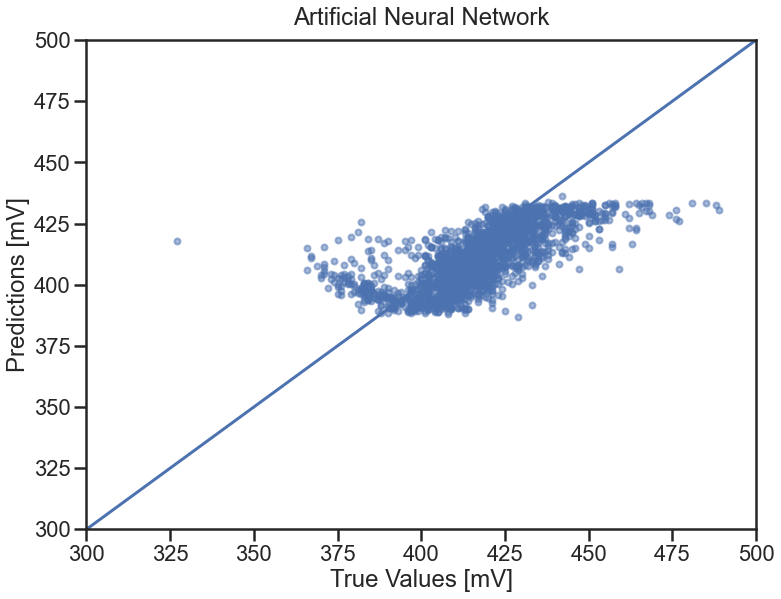

In [28]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Artificial Neural Network', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, test_predictions*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000]);

---

# Support vector regression

So the NN can make a good prediction but are there other algorithms who can do the job?

In [29]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

The general procedure for the use of an algorithm in Scikit learn is

* (Load the respective algorithm)
* Create an instance of the algorithm
* Fit the algorithm to the (training) data
* Make a prediction with the (test) data

Very often the hyperparameters in Scikit Learn work good right out of the box. But here we will do a hyperparameter search also to find good ones. To do so we

* define a dictionary with the parameter space,
* initiate an instance of a Support Vector Regression (SVR) with the static parameters,
* initiate an instance of a Randomized Search with cross validation,
* fit the search to the data.

Everything is put into a conditional because it takes some time. If we want to go with predefined values we can also do so.

In [30]:
optimize = 'n'

if optimize == 'y':
    hyper_params = {'gamma':[1, 10, 100],
                    'C':[1, 10, 100],
                    'epsilon':[0.001, 0.01, 0.1]}

    svr_tune = SVR(kernel='rbf')
    g_search = RandomizedSearchCV(svr_tune, hyper_params, cv=5, n_jobs=-1)
    g_search.fit(train_data, train_label)

    print('Best Score', g_search.best_score_)
    print('Best Estimator ', g_search.best_estimator_)

    print(g_search.best_estimator_.C, g_search.best_estimator_.gamma, g_search.best_estimator_.epsilon)

    best_C = g_search.best_estimator_.C
    best_gamma = g_search.best_estimator_.gamma
    best_epsilon = g_search.best_estimator_.epsilon
    
else:
    best_C = 100
    best_gamma = 10
    best_epsilon = 0.001 

No we can initiate the final SVR, use the best parameters and fit to the data.

In [31]:
svr_rbf = SVR(kernel='rbf', C=best_C, gamma=best_gamma, epsilon=best_epsilon)
y_svr = svr_rbf.fit(train_data, train_label)

Here me make some predictions and keep them for later.

In [32]:
predict_svr_train = y_svr.predict(train_data)
predict_svr = y_svr.predict(test_data)

predict_own_svr = y_svr.predict(NiFeCoCe_own.loc[:,'Ni':'Ce'])

And this is how the parity plot looks like.

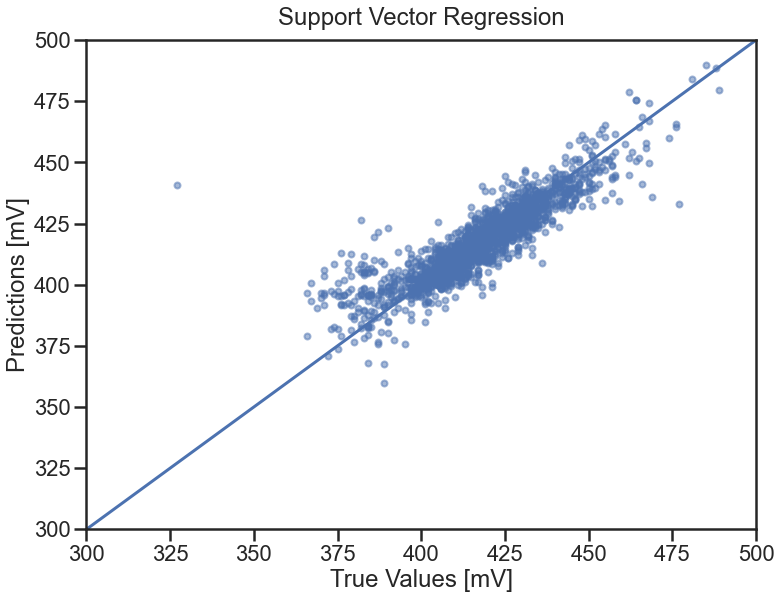

In [33]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Support Vector Regression', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_svr*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000]);

---

# k-Nearest Neighbour regression

Now we take a look how a k-Nearest Neighbour will perform on the data. Therefore we first import the algorithm from Scikit Learn.

In [34]:
from sklearn import neighbors

The most important parameter for this algorithm is the number of neighbours. To find the right amount we iterate of several neighbours and calculate the error on the prediction. This error is stored in a list to create a plot from the errors.

In [35]:
rmse_val = []
for K in range(50):
    K = K+1
    model_knn = neighbors.KNeighborsRegressor(n_neighbors = K)
    model_knn.fit(train_data, train_label)
    predict_knn = model_knn.predict(test_data)
    error = np.sqrt(mean_squared_error(test_label,predict_knn))
    rmse_val.append(error)

Now we create what in literature is called an ellbow curve. In that kind of curve we plot the collected error versus the nearest neighbours. You see the curve makes nice ellbow and after adding some neighbours the error is not going down any longer, it even raising. This is the right point to choose.

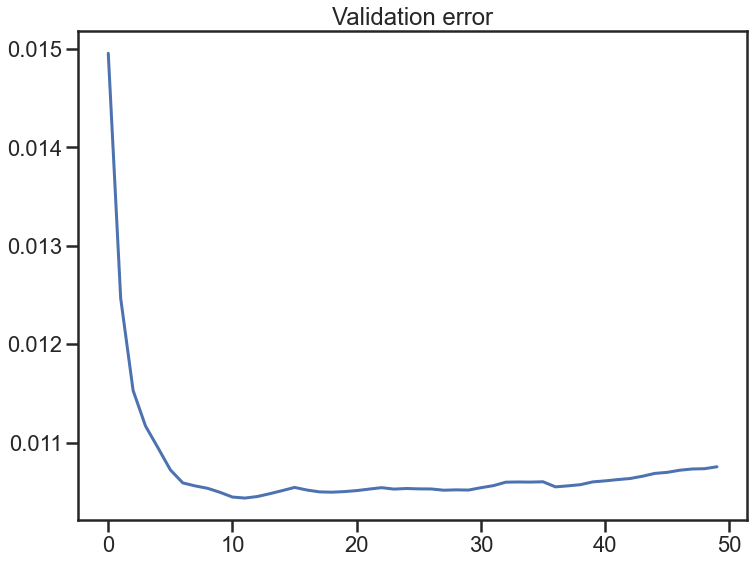

In [44]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.title('Validation error')
plt.plot(rmse_val);

Numpy makes it easy for us to find the minimum.

In [37]:
print(np.argmin(rmse_val))
best_k = np.argmin(rmse_val)

11


Before making actual predictions we initiate a new regressor with the optimal amount aof neighbours and fit to the training data.

In [38]:
model_knn = neighbors.KNeighborsRegressor(n_neighbors = 11)
model_knn.fit(train_data, train_label)

KNeighborsRegressor(n_neighbors=11)

Like before we make some predictions on the training and testing data and also on completely different wet chemistry data.

In [39]:
predict_knn_train=model_knn.predict(train_data)
predict_knn=model_knn.predict(test_data)

predict_own_knn=model_knn.predict(NiFeCoCe_own.loc[:,'Ni':'Ce'])

We plot the predictions on the test set in the next parity plot.

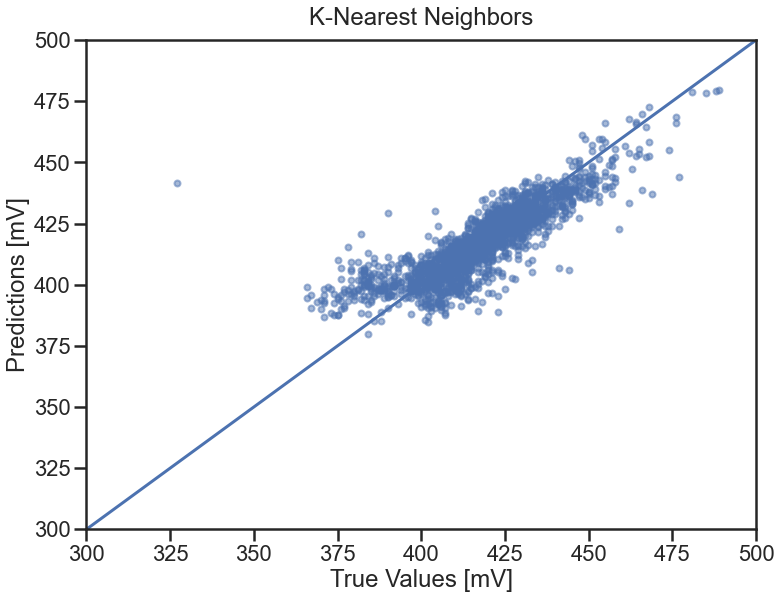

In [40]:
sns.set()
sns.set(style='ticks', context='poster')
plt.figure(figsize=(12,9))

plt.xlim((300,500))
plt.ylim((300,500))
plt.title('K-Nearest Neighbors', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_knn*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000]);

---

# Prediction overview

Now we make an overview of all the predictions made. The code is a bit lenghty but every subplot is more or less copy and paste from what we already had before.

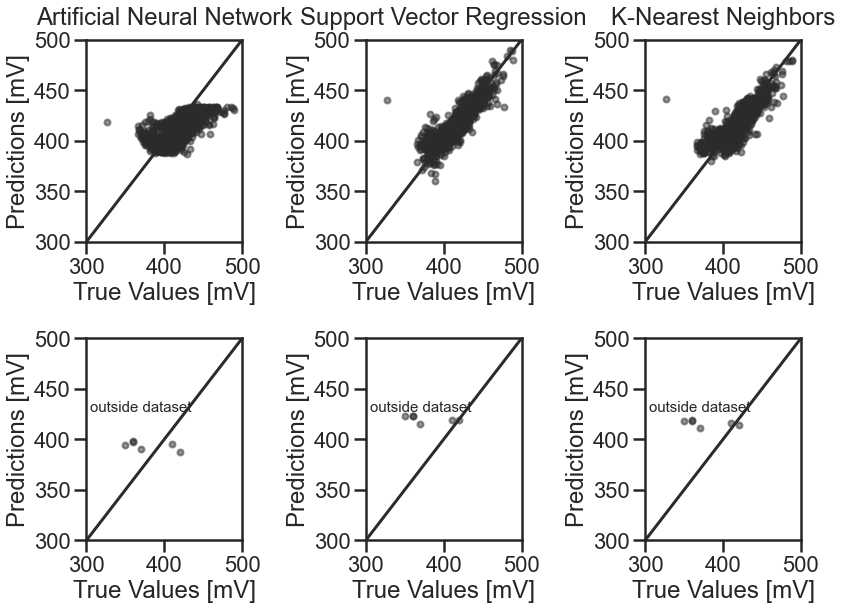

In [41]:
sns.set()
sns.set(style='ticks', context='poster', palette='Greys_r')
plt.figure(figsize=(12,9))

plt.subplot(231)
plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Artificial Neural Network', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, test_predictions*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(232)
plt.xlim((300,500))
plt.ylim((300,500))
plt.title('Support Vector Regression', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_svr*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(233)
plt.xlim((300,500))
plt.ylim((300,500))
plt.title('K-Nearest Neighbors', pad=15)
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(test_label*1000, predict_knn*1000, marker='.', alpha=0.5)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(234)
plt.xlim((300,500))
plt.ylim((300,500))
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(NiFeCoCe_own.loc[:,'Overpotential'], predict_own_data*1000, marker='.', alpha=0.5)
plt.annotate('outside dataset', xy=(305,428), size=15)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(235)
plt.xlim((300,500))
plt.ylim((300,500))
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(NiFeCoCe_own.loc[:,'Overpotential'], predict_own_svr*1000, marker='.', alpha=0.5)
plt.annotate('outside dataset', xy=(305,428), size=15)
plt.plot([-1000, 1000], [-1000, 1000])

plt.subplot(236)
plt.xlim((300,500))
plt.ylim((300,500))
plt.xlabel('True Values [mV]')
plt.ylabel('Predictions [mV]')
plt.scatter(NiFeCoCe_own.loc[:,'Overpotential'], predict_own_knn*1000, marker='.', alpha=0.5)
plt.annotate('outside dataset', xy=(305,428), size=15)
plt.plot([-1000, 1000], [-1000, 1000])

plt.tight_layout()

What we see is that even quite simple algorithms can make decent predictions on such a dataset. It is not always to head off for Deep Learning. It depends mostly on the right choice of algorithm for the respective data. What we can also see on the additional data is that when data is close to the data the algorithm is trained on then we will get better predictions. For example the points outside the dataset have some kind of porosity what the original data does not.

---

# Calculating overall metrics

In ordner to be a liitle more quantitave we calculate the mean squared error and the R2 score for all algorithms and datasets in an equal manner.

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mse_ann = mean_squared_error(test_label,test_predictions)
mse_ann_train = mean_squared_error(train_label,train_predictions)

mse_svr = mean_squared_error(test_label,predict_svr)
mse_svr_train = mean_squared_error(train_label,predict_svr_train)

mse_knn = mean_squared_error(test_label,predict_knn)
mse_knn_train = mean_squared_error(train_label,predict_knn_train)

r2_ann_train = r2_score(train_label,train_predictions)
r2_ann = r2_score(test_label,test_predictions)

r2_svr_train = r2_score(train_label,predict_svr_train)
r2_svr = r2_score(test_label,predict_svr)

r2_knn_train = r2_score(train_label,predict_knn_train)
r2_knn = r2_score(test_label,predict_knn)

Here we will make some bar plots of these metrics. Do get a decent look we do some customizations like defining custom names, colours and a custom legend.

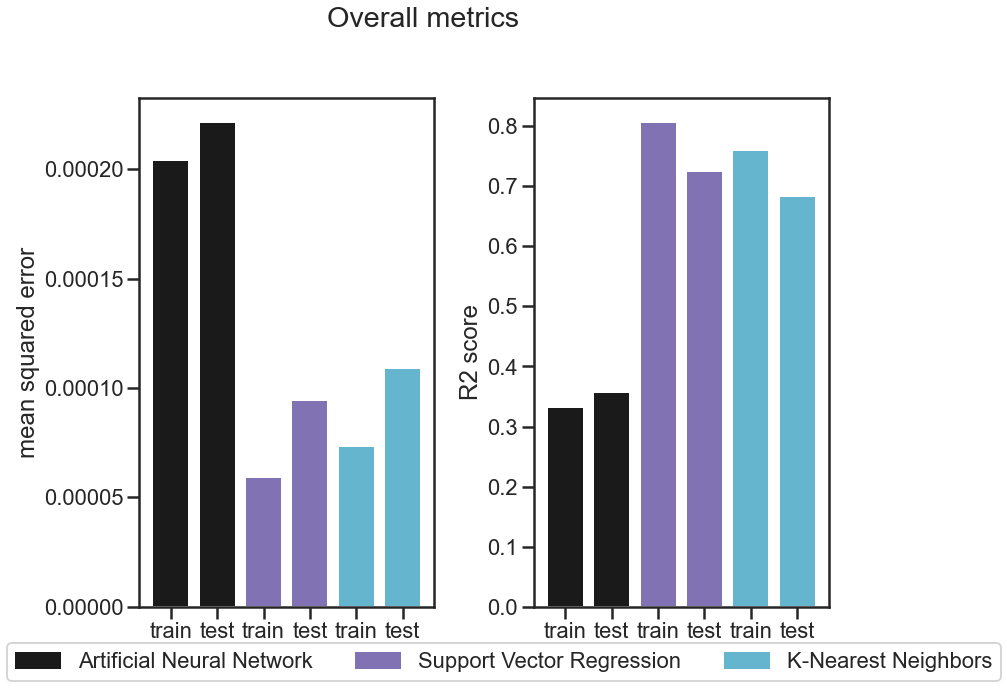

In [43]:
sns.set()
sns.set(style='ticks', context='poster', palette='magma')

ann = mpatches.Patch(color='k', label='Artificial Neural Network')
svr = mpatches.Patch(color='m', label='Support Vector Regression')
knn = mpatches.Patch(color='c', label='K-Nearest Neighbors')

names = ['train', 'test', 'train', 'test', 'train', 'test']
pos = range(len(names))
colors = ['k', 'k', 'm', 'm', 'c', 'c']
rotation = 0

plt.figure(figsize=(12,9))
plt.suptitle('Overall metrics', y=1.02)
plt.subplot(121)
plt.bar(pos, [mse_ann_train, mse_ann, mse_svr_train, mse_svr,mse_knn_train, mse_knn], color=colors)
plt.xticks(pos, names,rotation=rotation)
plt.ylabel('mean squared error')

plt.subplot(122)
plt.bar(pos, [r2_ann_train,r2_ann, r2_svr_train, r2_svr,r2_knn_train, r2_knn], color=colors)
plt.xticks(pos, names, rotation=rotation)
plt.ylabel('R2 score')

plt.tight_layout()
plt.legend(loc='upper center', handles=[ann, svr, knn], ncol=3, bbox_to_anchor=(-0.1, -0.05));

And again , here it is even more clear to see that the simple algorithms are able to outperform the more state of the art Neural Newtork. So it will be always important to choose the right algorithm for the data you have.

---

# Summary

That final passage brings us to the take home mnessages:

* Machine Learning can be used to predict the overpotential of literature datasets and catalysts from our own work

* Simple models like Support Vector Regression are able to outperform more complex Artificial Neural Networks

* Visualization, preprocessing of data and tuning of hyperparameters are important tasks for Machine Learning